In [52]:
from sns_toolbox.connections import NonSpikingPatternConnection, NonSpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.renderer import render

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
import sys

(-0.5, 31.5, 31.5, -0.5)

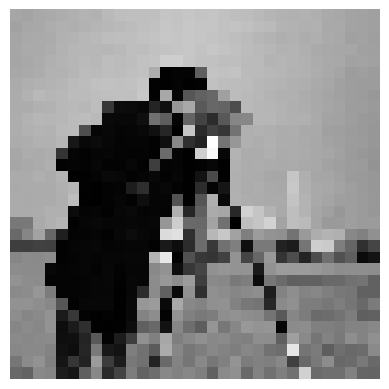

In [2]:
img = cv.imread('/home/will/Pictures/sample_images/cameraman.png')   # load image file

shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.figure()
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

In [3]:
# General Network
R = 20.0
net = Network(name='L1')
img_flat = img_flat*R/255.0

In [4]:
# Retina
neuron_retina = NonSpikingNeuron()
net.add_population(neuron_retina,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

In [5]:
def calc_g_max(g_m, e_r, u_str, u_pre_str, R, del_e):
    g_max = (g_m * (e_r - u_str))/((u_pre_str/R)*(u_str-del_e))
    return g_max

1.0
0.06666666666666667


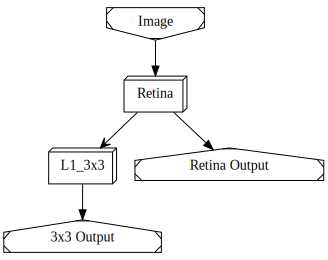

In [6]:
# L1 3x3
neuron_lamina = NonSpikingNeuron(resting_potential=R)
net.add_population(neuron_lamina, shape, name='L1_3x3')

del_e_in = -1*R

center_str = 0
g_max_ctr = calc_g_max(1,R,center_str,R,R,del_e_in)
print(g_max_ctr)

edge_str = (7/8)*R
g_max_edge = calc_g_max(1,R,edge_str,R,R,del_e_in)
print(g_max_edge)

g_max_kernel = np.array([[g_max_edge, g_max_edge, g_max_edge],
                         [g_max_edge, g_max_ctr, g_max_edge],
                         [g_max_edge, g_max_edge, g_max_edge]])

del_e_kernel = np.zeros([3,3]) + del_e_in

e_lo_kernel = np.zeros([3,3])
e_hi_kernel = np.zeros([3,3]) + R
connection_L1_3x3 = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_L1_3x3,'Retina','L1_3x3',name='3x3') # connect the retina to the lamina
net.add_output('L1_3x3',name='3x3 Output')  # add a vector output from the lamina

render(net)

1.0
0.06666666666666667
0.03225806451612903


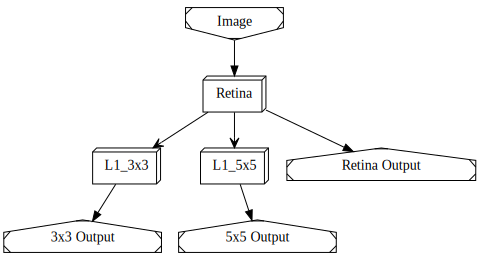

In [7]:
# L1 5x5
neuron_lamina = NonSpikingNeuron(resting_potential=R)
net.add_population(neuron_lamina, shape, name='L1_5x5')

del_e_in = -1*R
del_e_ex = 3*R

center_str = 0
g_max_ctr = calc_g_max(1,R,center_str,R,R,del_e_in)
print(g_max_ctr)

inner_edge_str = (7/8)*R
g_max_edge_inner = calc_g_max(1,R,inner_edge_str,R,R,del_e_in)
print(g_max_edge_inner)

outer_edge_str = (17/16)*R
g_max_edge_outer = calc_g_max(1,R,outer_edge_str,R,R,del_e_ex)
print(g_max_edge_outer)

g_max_kernel = np.array([[g_max_edge_outer, g_max_edge_outer, g_max_edge_outer, g_max_edge_outer, g_max_edge_outer],
                         [g_max_edge_outer, g_max_edge_inner, g_max_edge_inner, g_max_edge_inner, g_max_edge_outer],
                         [g_max_edge_outer, g_max_edge_inner, g_max_ctr, g_max_edge_inner, g_max_edge_outer],
                         [g_max_edge_outer, g_max_edge_inner, g_max_edge_inner, g_max_edge_inner, g_max_edge_outer],
                         [g_max_edge_outer, g_max_edge_outer, g_max_edge_outer, g_max_edge_outer, g_max_edge_outer]])

del_e_kernel = np.array([[del_e_ex, del_e_ex, del_e_ex, del_e_ex, del_e_ex],
                         [del_e_ex, del_e_in, del_e_in, del_e_in, del_e_ex],
                         [del_e_ex, del_e_in, del_e_in, del_e_in, del_e_ex],
                         [del_e_ex, del_e_in, del_e_in, del_e_in, del_e_ex],
                         [del_e_ex, del_e_ex, del_e_ex, del_e_ex, del_e_ex]])

e_lo_kernel = np.zeros([5,5])
e_hi_kernel = np.zeros([5,5]) + R
connection_L1_5x5 = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_L1_5x5,'Retina','L1_5x5',name='5x5') # connect the retina to the lamina
net.add_output('L1_5x5',name='5x5 Output')  # add a vector output from the lamina

render(net)

In [12]:
dt = neuron_retina.params['membrane_capacitance']/neuron_retina.params['membrane_conductance']  # calculate the ideal dt
t_max = 15  # run for 15 ms
steps = int(t_max/dt)   # number of steps to simulate

model = net.compile(backend='numpy',dt=dt,debug=False) # compile using the numpy backend

1 / 3 steps
2 / 3 steps
3 / 3 steps


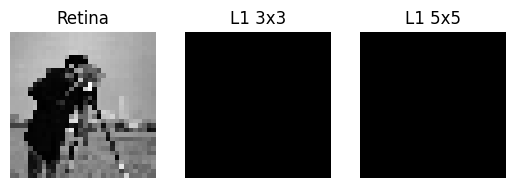

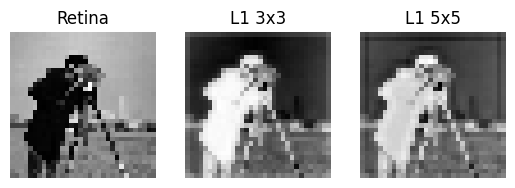

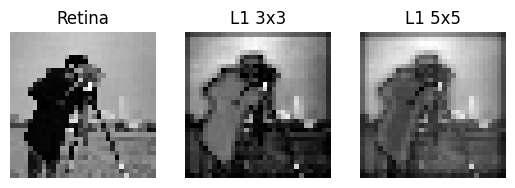

In [13]:
for i in range(steps):
    print('%i / %i steps'%(i+1,steps))
    plt.figure()    # create a figure for live plotting the retina and lamina states
    plt.subplot(1,3,1)
    plt.title('Retina')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('L1 3x3')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('L1 5x5')
    plt.axis('off')

    out = model(img_flat)   # run the network for one dt
    retina = out[:flat_size]    # separate the retina and lamina states
    lamina_small = out[flat_size:2*flat_size]
    lamina_large = out[2*flat_size:]
    retina_reshape = np.reshape(retina,shape)   # reshape to from flat to an image
    lamina_small_reshape = np.reshape(lamina_small,shape)
    lamina_large_reshape = np.reshape(lamina_large,shape)
    plt.subplot(1,3,1)  # plot the current state
    plt.imshow(retina_reshape,cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(lamina_small_reshape, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(lamina_large_reshape, cmap='gray')

1.0
0.06666666666666667
0.03225806451612903


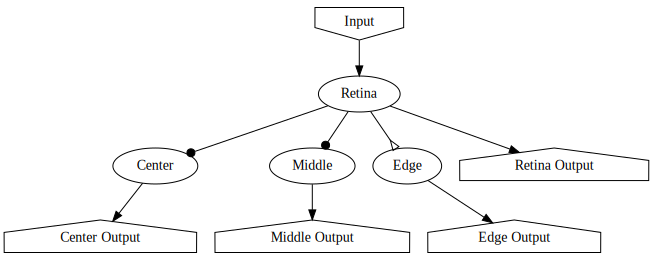

In [29]:
field_net = Network(name='L1 Field')
neuron_retina = NonSpikingNeuron(membrane_capacitance=1.0)
field_net.add_neuron(neuron_retina, name='Retina', initial_value=R)
field_net.add_input('Retina')
field_net.add_output('Retina', name='Retina Output')

neuron_lamina = NonSpikingNeuron(resting_potential=R, membrane_capacitance=1.0)
field_net.add_neuron(neuron_lamina, name='Center')
field_net.add_neuron(neuron_lamina, name='Middle')
field_net.add_neuron(neuron_lamina, name='Edge')

del_e_in = -1*R
del_e_ex = 3*R

center_str = 0
g_max_ctr = calc_g_max(1,R,center_str,R,R,del_e_in)
print(g_max_ctr)

inner_edge_str = (7/8)*R
g_max_edge_inner = calc_g_max(1,R,inner_edge_str,R,R,del_e_in)
print(g_max_edge_inner)

outer_edge_str = (17/16)*R
g_max_edge_outer = calc_g_max(1,R,outer_edge_str,R,R,del_e_ex)
print(g_max_edge_outer)

connection_center = NonSpikingSynapse(max_conductance=g_max_ctr, reversal_potential=del_e_in, e_hi=R)
connection_middle = NonSpikingSynapse(max_conductance=g_max_edge_inner, reversal_potential=del_e_in, e_hi=R)
connection_edge = NonSpikingSynapse(max_conductance=g_max_edge_outer, reversal_potential=del_e_ex, e_hi=R)

field_net.add_connection(connection_center,'Retina','Center')
field_net.add_output('Center',name='Center Output')
field_net.add_connection(connection_middle,'Retina','Middle')
field_net.add_output('Middle',name='Middle Output')
field_net.add_connection(connection_edge,'Retina','Edge')
field_net.add_output('Edge',name='Edge Output') 

render(field_net)

In [32]:
dt = 0.1
t_max = 15  # run for 15 ms
t = np.arange(0, t_max, dt)

model_field = field_net.compile(backend='numpy',dt=dt,debug=False) # compile using the numpy backend

Iapp = np.array([[R]])
data = np.zeros([len(t),field_net.get_num_outputs_actual()])

for i in range(len(t)):
    data[i,:] = model_field.forward(Iapp[0,:])
    
data = data.transpose()

Text(0.5, 1.0, 'Edge')

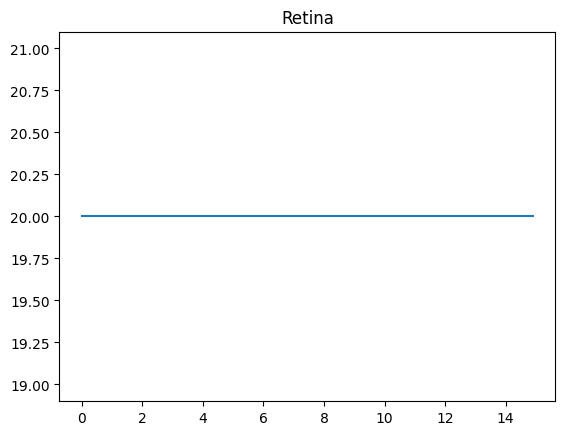

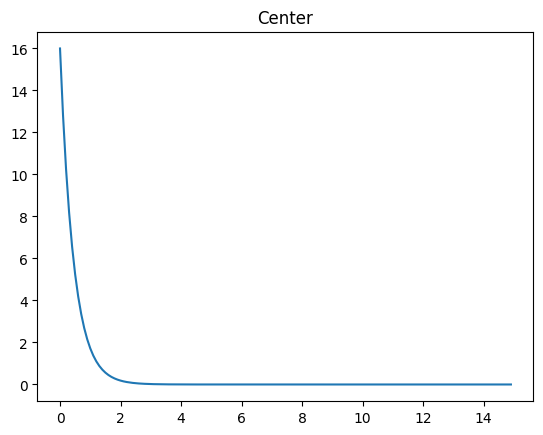

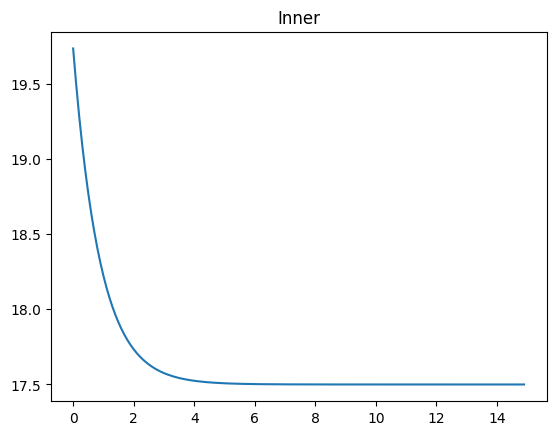

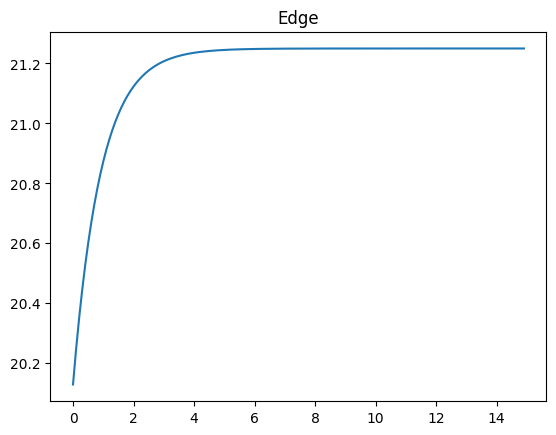

In [33]:
plt.figure()
plt.plot(t, data[:][0])
plt.title('Retina')
plt.figure()
plt.plot(t, data[:][1])
plt.title('Center')
plt.figure()
plt.plot(t, data[:][2])
plt.title('Inner')
plt.figure()
plt.plot(t, data[:][3])
plt.title('Edge')

(4, 150)


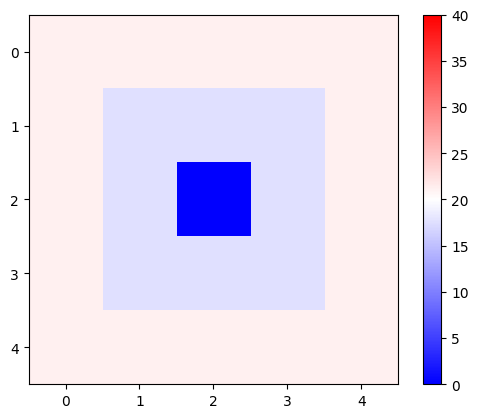

In [55]:
receptive_field = np.array([[data[3][-1], data[3][-1], data[3][-1], data[3][-1], data[3][-1]],
                            [data[3][-1], data[2][-1], data[2][-1], data[2][-1], data[3][-1]],
                            [data[3][-1], data[2][-1], data[1][-1], data[2][-1], data[3][-1]],
                            [data[3][-1], data[2][-1], data[2][-1], data[2][-1], data[3][-1]],
                            [data[3][-1], data[3][-1], data[3][-1], data[3][-1], data[3][-1]]])

field_cmap_vals = [0, R, 2*R]
field_cmap_colors = ['blue', 'white', 'red']
field_cmap_norm = plt.Normalize(min(field_cmap_vals), max(field_cmap_vals))
field_cmap_tuples = list(zip(map(field_cmap_norm,field_cmap_vals), field_cmap_colors))
field_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", field_cmap_tuples)

plt.figure()
plt.imshow(receptive_field, cmap=field_cmap, norm=field_cmap_norm)
plt.colorbar()
print(data.shape)